In [1]:
from models.pois_allhist_glm import Pois_AllHist_GLM, GLM_Encoder
#from models.bern_allhist_glm import Bern_AllHist_GLM, GLM_Encoder


import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
Z_file = "spk_loc.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
Z = torch.from_numpy(Z)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 200
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 100000
iter_no = 20
epoch_no = 15
layer_no = 3

In [4]:
Z_train = Z[:T_train].float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)


In [5]:
"""
batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)
"""

train_idx = torch.tensor([0, 
                         100000,
                         200000]).repeat((4))

In [6]:
decoder = Pois_AllHist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)
#encoder = NN_Encoder(C_syn_e, C_syn_i, T_no, layer_no, device)
encoder = GLM_Encoder(C_syn_e, C_syn_i, T_no, device)

#enc_optimizer = torch.optim.SGD(encoder.parameters(), lr = 0.05, momentum=0.9)
#dec_optimizer = torch.optim.SGD(decoder.parameters(), lr = 0.05, momentum=0.9)

enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.001)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 0.001)

encoder.to(device).float()
decoder.to(device).float()
print(sum(p.numel() for p in encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in decoder.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss()

160
198


In [7]:
#batch_E_neural = train_E_neural
#batch_I_neural = train_I_neural
#batch_V = V_train
#batch_Z = Z_train

for i in tnrange(iter_no):
    encoder.eval()
    decoder.train()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    batch_Z = Z_train[batch_idx : batch_idx+batch_size].to(device)
    
    for j in range(50):
        dec_optimizer.zero_grad()

        Z_enc, P_enc = encoder(batch_Z, batch_E_neural, batch_I_neural)
        
        Z_in = torch.zeros(batch_size, sub_no).to(device)
        Z_in[:,0] = Z_in[:,0] + batch_Z
        Z_in[:,1:] = Z_in[:,1:] + Z_enc
        Z_in = Z_in.detach()
        
        P_dec, _ = decoder.train_forward(batch_E_neural, batch_I_neural, Z_in)
        
        dec_loss = bce_criterion(P_dec, Z_in)
        #print("Dec", loss.item())
        dec_loss.backward()
        dec_optimizer.step()
    
    encoder.train()
    decoder.eval()
    
    Z_dec, P_dec, _ = decoder.test_forward(batch_E_neural, batch_I_neural)
    
    for j in range(50):
        enc_optimizer.zero_grad()
        
        Z_enc, P_enc = encoder(batch_Z, batch_E_neural, batch_I_neural)
        #print("forward")

        enc_loss = bce_criterion(P_enc, P_dec[:,1:].detach())
        #print("Enc", loss.item())
        enc_loss.backward()
        enc_optimizer.step()
        
    encoder.eval()
    decoder.eval()
    
    
    test_Z_enc, test_P_enc = encoder(Z_test, test_E_neural, test_I_neural)
    test_Z_dec, test_P_dec, test_filters = decoder.test_forward(test_E_neural, test_I_neural)
    test_loss = bce_criterion(test_P_dec[:,0], Z_test)
        
    print(i, "NLL: ", np.round(test_loss.item(), 6),
          "Pred Spikes: ", np.round(torch.sum(test_P_dec).item(), 6),
         "Enc Spikes: ", np.round(torch.sum(test_P_enc).item(), 6),
         "Train Enc: ", np.round(torch.mean(enc_loss).item(), 6),
         "Train Dec: ", np.round(torch.mean(dec_loss).item(), 6))
    
    

<ipython-input-7-9e25ddad1a49>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 NLL:  0.007182 Pred Spikes:  714.013428 Enc Spikes:  618.914551 Train Enc:  0.017329 Train Dec:  0.015677
1 NLL:  0.007059 Pred Spikes:  698.833496 Enc Spikes:  617.364075 Train Enc:  0.017291 Train Dec:  0.01582
2 NLL:  0.006952 Pred Spikes:  692.64978 Enc Spikes:  618.535278 Train Enc:  0.017321 Train Dec:  0.015576
3 NLL:  0.006969 Pred Spikes:  688.408691 Enc Spikes:  620.555664 Train Enc:  0.017366 Train Dec:  0.015929
4 NLL:  0.007105 Pred Spikes:  687.282959 Enc Spikes:  618.085571 Train Enc:  0.017308 Train Dec:  0.015833
5 NLL:  0.00715 Pred Spikes:  686.068848 Enc Spikes:  617.317505 Train Enc:  0.017292 Train Dec:  0.015611
6 NLL:  0.006992 Pred Spikes:  685.127563 Enc Spikes:  616.837952 Train Enc:  0.017279 Train Dec:  0.015841
7 NLL:  0.006958 Pred Spikes:  676.888794 Enc Spikes:  617.061768 Train Enc:  0.017287 Train Dec:  0.015258



RuntimeError: CUDA error: device-side assert triggered

In [8]:
print(torch.sum(test_Z_dec[:,0]))

tensor(100., device='cuda:0', grad_fn=<SumBackward0>)


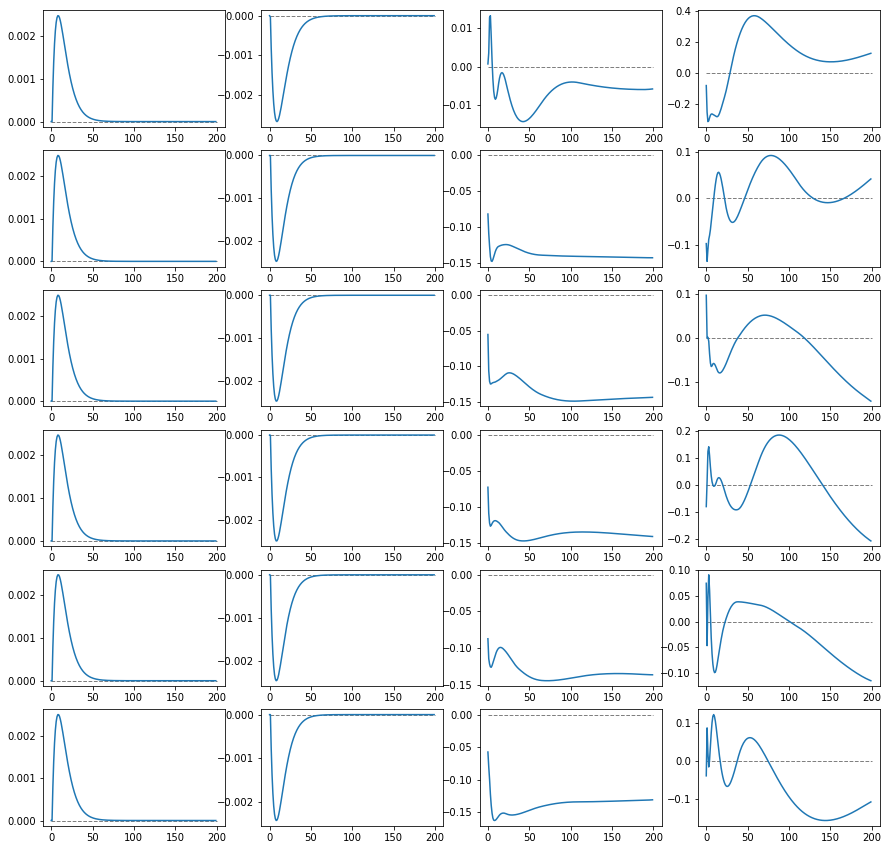

In [9]:
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(15,15))
for row in range(6):
    for col in range(4):
        axs[row,col].plot(test_filters[col*6+row].cpu().detach().numpy()[:T_no])
        axs[row,col].hlines(y=0,xmin=0,xmax=T_no,linestyle="--", color="gray", linewidth=1)

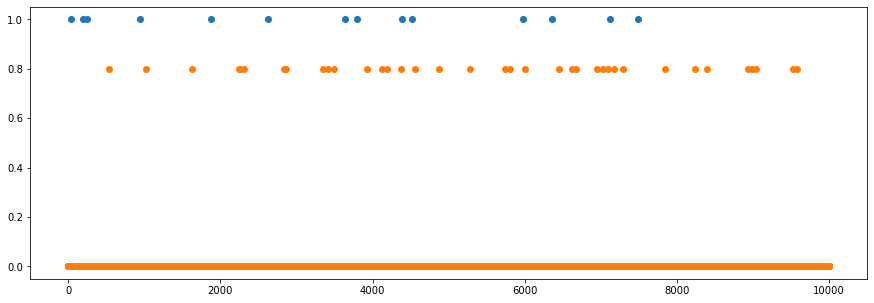

In [10]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(10000), test_Z_dec[16000:26000:,0].cpu().detach().numpy())
plt.scatter(np.arange(10000), Z_test[16000:26000].cpu().detach().numpy()*0.8)

(0.0, 0.03)

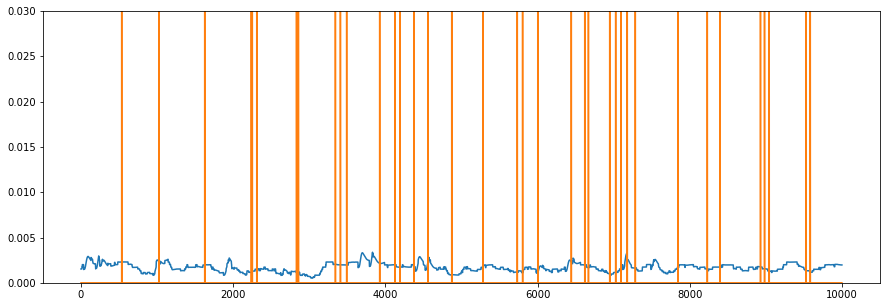

In [11]:
plt.figure(figsize = (15,5))
plt.plot(test_P_dec[16000:26000,0].cpu().detach().numpy())
plt.plot(Z_test[16000:26000].cpu().detach().numpy())
plt.ylim(0,0.03)

In [12]:
print(decoder.Theta)

Parameter containing:
tensor([-6.0819, -6.0007, -5.9962, -6.0194, -6.0127, -5.9833], device='cuda:0',
       requires_grad=True)


In [13]:
print(decoder.Tau_syn)

Parameter containing:
tensor([[2.0000, 2.0820],
        [2.0043, 1.9768],
        [1.9957, 1.9944],
        [1.9901, 2.0027],
        [2.0058, 1.9764],
        [2.0104, 1.9836]], device='cuda:0', requires_grad=True)
